In [813]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine,euclidean
import pandas as pd
%matplotlib inline
from pylab import rcParams


import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 0. Generate data

## a) gaussian distribution

In [10]:
def generate_2d_gaussian(mean, cov, size, label):
    x = np.random.multivariate_normal(mean, cov, (size))
    y = np.full((size,1), label)
    return x, y

In [929]:
size1 = 1000
label1 = 0
mean1 = (20, 6)
cov1 = [[6,3], [3, 4]]
x1,y1 = generate_2d_gaussian(mean1, cov1, size1, label1)

size2 = 200
label2 = 1
mean2 = (30, 10)
cov2 = [[5,2], [2, 6]]
x2,y2 = generate_2d_gaussian(mean2, cov2, size2, label2)

In [930]:
from pylab import rcParams
rcParams['figure.figsize'] = 5,5

Text(0, 0.5, 'x2')

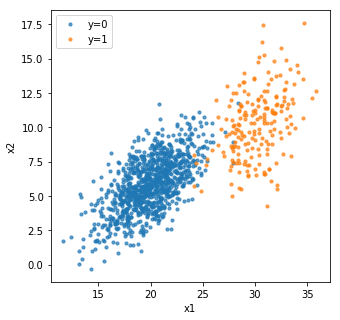

In [931]:
plt.scatter(x1[:,0],x1[:,1],s=10,alpha=0.7)
plt.scatter(x2[:,0],x2[:,1],s=10,alpha=0.7)
plt.legend(["y=0","y=1"])
plt.xlabel("x1")
plt.ylabel("x2")

In [932]:
x_all = np.concatenate((x1,x2))
y_all = np.concatenate((y1,y2))

In [933]:
N = len(x_all)
train = int(N*0.75)

train_ind = np.random.choice(N, train, replace=False)
test_ind = np.array([ind for ind in range(N) if ind not in train_ind])

In [934]:
len(train_ind) + len(test_ind)

1200

In [935]:
x_train = x_all[train_ind]
y_train = y_all[train_ind]
x_test = x_all[test_ind]
y_test = y_all[test_ind]

# 1. decision boundary to transfer real values to class

## 1D input

In [936]:
rcParams['figure.figsize'] = 5,5

In [937]:
x_train1 = x_all[train_ind][:,0]
y_train1 = y_all[train_ind]
x_test1 = x_all[test_ind][:,0]
y_test1 = y_all[test_ind]

In [ ]:
data = list(zip(x_train1, y_train1))
data0 = np.array([d for d in data if d[1] == 0])
data1 = np.array([d for d in data if d[1] == 1])

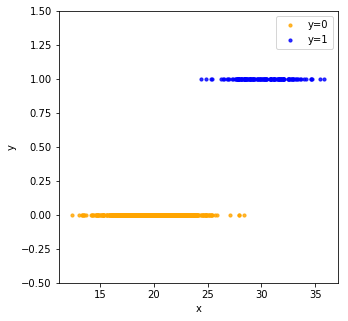

In [964]:
# in the same 1d with the linear regression line
plt.scatter(data0[:,0], data0[:,1], s = 10, alpha=0.8, c='orange')
plt.scatter(data1[:,0], data1[:,1], s = 10, alpha=0.8, c = 'blue')
plt.ylim([-0.5,1.5])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['y=0','y=1'])

In [939]:
reg1 = LinearRegression().fit(x_train1.reshape(-1,1), y_train)
y_pred1 = reg1.predict(x_train1.reshape(-1,1))

([<matplotlib.axis.XTick at 0x13bc13c18>,
 <a list of 2 Text xticklabel objects>)

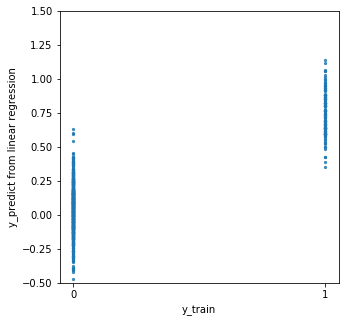

In [940]:
plt.scatter(y_train1, y_pred1, s = 5,alpha=0.8)
plt.xlabel("y_train")
plt.ylabel("y_predict from linear regression") 
plt.ylim([-.5,1.5])
plt.xticks([0,1])

In [941]:
def discrate_boundary(y_pred, y_train, boundary):
    y_pred_discrete = []
    for y_ in y_pred:
        if y_ > boundary:
            y_new = 1
        else: 
            y_new = 0
        y_pred_discrete.append(y_new)
    y_pred_discrete = np.array(y_pred_discrete)
    mse = mean_squared_error(y_train, y_pred_discrete)
    diff = (y_pred_discrete != y_train.flatten())
    mis = 1.*diff.sum() / len(diff)
    return mse, mis

In [942]:
results_1d = dict()
boundarys = np.linspace(label1,label2, 100)
for i, boundary in enumerate (boundarys):
    mse, mis = discrate_boundary(y_pred1, y_train1, boundary)
    results_1d[i] = boundary, mse, mis
df_1d = pd.DataFrame.from_dict(results_1d, orient='index',columns=['boundary','mse','mis'])

Text(0, 0.5, 'misclassificate rate')

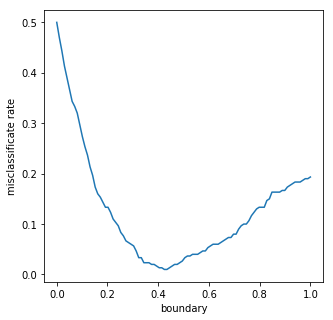

In [943]:
plt.plot(df_1d['boundary'],df['mis'])
plt.xlabel('boundary')
plt.ylabel('misclassificate rate')

In [944]:
df_1d.sort_values('mis').head(3)

,boundary,mse,mis
46,0.464646,0.008889,0.008889
47,0.474747,0.008889,0.008889
48,0.484848,0.008889,0.008889


In [1050]:
rcParams['figure.figsize'] = 5,5

# 2. use sigmoid to transformat real value to continous value

In [462]:
def sigmoid(x, slope=1, shift=0):
    # monotonously squeeze any R [-inf, inf] to [0,1] range
    # use exp(x) positive 0-inf
    # sigmoid function
    return 1 / (slope * np.exp(- (x-shift)) + 1)

In [471]:
slopes = [0.1,1,10]
shifts = [-1, 0.5, 5]
x = np.linspace(-10,10,100)

In [472]:
rcParams['figure.figsize'] = 5,5

Text(0.5, 1.0, 'sigmoid tranformation with different slopes')

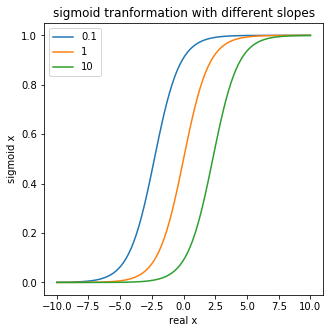

In [478]:
for slope in slopes:
    y = [sigmoid(x_,slope) for x_ in x]
    plt.plot(x,y)
plt.legend(slopes)
plt.xlabel('real x')
plt.ylabel('sigmoid x')
plt.title('sigmoid tranformation with different slopes')

Text(0.5, 1.0, 'sigmoid tranformation with different shifts')

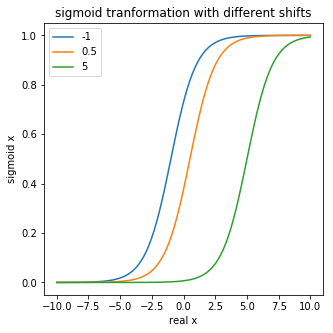

In [479]:
for shift in shifts:
    y = [sigmoid(x_,shift=shift) for x_ in x]
    plt.plot(x,y)
plt.legend(shifts)
plt.xlabel('real x')
plt.ylabel('sigmoid value')
plt.title('sigmoid tranformation with different shifts')

In [480]:
def convert_real_to_probability(y_pred, y_test, boundary, slope=1, shift=0):
    # monotonously squeeze any R to [0,1] range
    # use exp(x) positive 0-inf
    y_pred_sigmoid = np.array([sigmoid(y_, slope, shift) for y_ in y_pred])
    return discrate_boundary(y_pred_sigmoid, y_test, boundary)

In [482]:
convert_real_to_probability(y_pred, y_test, boundary=0.5, slope=1, shift=0)

(0.52, 0.52)

In [484]:
results2 = dict()
boundarys = np.linspace(label1,label2, 100)
for i, boundary in enumerate (boundarys):
    mse, mis = convert_real_to_probability(y_pred, y_test, boundary)
    results2[i] = boundary, mse, mis
df2 = pd.DataFrame.from_dict(results2, orient='index',columns=['boundary','mse','mis'])

Text(0, 0.5, 'misclassificate rate')

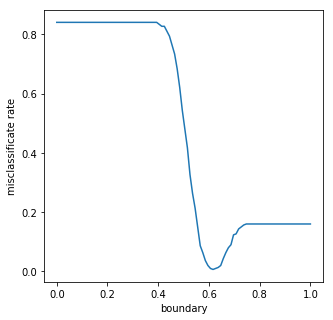

In [487]:
plt.plot(df2['boundary'],df2['mis'])
plt.xlabel('boundary')
plt.ylabel('misclassificate rate')

# 3. Newton Method

In [779]:
def func1(x):
    if x > 0:
        return np.sin(x) + np.log(x) -1
    else:
        print ("invalid iteration")
        return None
def deri_func1(x):
    return np.cos(x) + 1./x
def func2(x):
    return -x**2  + 100*x - 1000
def deri_func2(x):
    return -2*x + 100

def func3(x):
    return x**3  - 5*x
def deri_func3(x):
    return 3*x**2 - 5

In [780]:
# find the root of high order function f(x) = 0
# x_n+1 = x_n - f(x_n)/ f'(x_n)

xs = np.linspace(1,200,1000)
ys1 = [func1(x) for x in xs]
ys2 = [func2(x) for x in xs]
xs3 = np.linspace(-10,10,1000)
ys3 = [func3(x) for x in xs3]

In [754]:
def plot(xs,ys,xlim,i):
    plt.plot(xs,ys)
    plt.xlim([xs.min(),xlim])
    plt.plot([xs.min(),xlim],[0,0],'r--',linewidth=1)
    plt.scatter(xs[i],ys[i],c='orange',s=30)

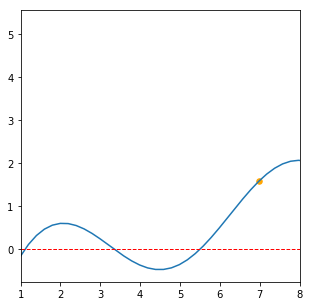

In [755]:
plot(xs,ys1,8,30)

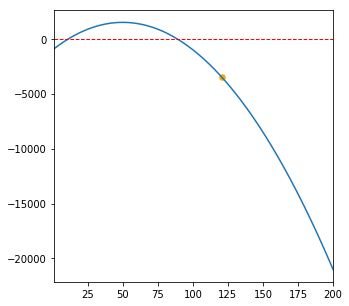

In [756]:
plot(xs,ys2,200,600)

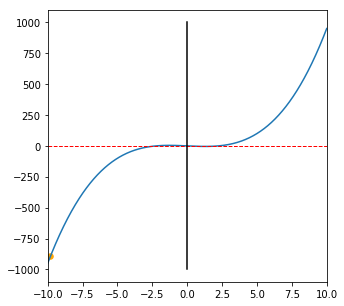

In [784]:
plot(xs3,ys3,10,10)
plt.xlim([-10,10])
plt.plot([0,0],[-1000,1000], c='black')

In [772]:
# x_n+1 = x_n - f(x_n)/ f'(x_n)
# problem 1: horizontal curve, stationary point
# problem 2: many roots, approximate the wrong root, due to stationary point, another side
# problem 3: bounce back and forth ...oscilating sequence, no progress
# point of reflection at the root

def is_converge_input(x_old, f, epsilon=1e-6):
    if abs(f(x_old)) < 1e-6: return True
    else: return False
    
def is_converge_output(x_old, x_new, epsilon=1e-6):
    if abs(x_old - x_new) < epsilon: return True
    else: return False
    

def newton_method_input(x_old, f, df, epsilon=1e-6):
    if f(x_old): # make sure if satisfy the log format of function
        if is_converge_input(x_old, f, epsilon):
            return x_old
        else:
            x_new = x_old - f(x_old) / df(x_old)
            return newton_method(x_new, f, df, epsilon)
        
def newton_method_output(x_old, f, df, epsilon=1e-6):
    if f(x_old): # make sure if satisfy the log format of function
        x_new = x_old - f(x_old) / df(x_old)
        if is_converge_output(x_old, x_new, epsilon):
            return x_new
        else:
            return newton_method(x_new, f, df, epsilon)

In [768]:
x_olds = [1.5, 3.2, 4.3, 4.4, 6, 4.5]
# 4.5 not converge
for x_old in x_olds:
    x_new_input = newton_method_input(x_old, func1, deri_func1)
    x_new_output = newton_method_output(x_old, func1, deri_func1)
    if x_new_input:
        print ("intial value is %.2f, newton method root with input convergence is %.2f"%(x_old,x_new_input))
        print ("intial value is %.2f, newton method root with output convergence is %.2f"%(x_old,x_new_output))

intial value is 1.50, newton method root with input convergence is 1.11
intial value is 1.50, newton method root with output convergence is 1.11
intial value is 3.20, newton method root with input convergence is 3.35
intial value is 3.20, newton method root with output convergence is 3.35
intial value is 4.30, newton method root with input convergence is 1.11
intial value is 4.30, newton method root with output convergence is 1.11
invalid iteration
invalid iteration
intial value is 6.00, newton method root with input convergence is 5.50
intial value is 6.00, newton method root with output convergence is 5.50


RecursionError: maximum recursion depth exceeded in comparison

In [769]:
x_olds = [10,25,70,120]
# 4.5 not converge
for x_old in x_olds:
    x_new_input = newton_method_input(x_old, func2, deri_func2)
    x_new_output = newton_method_output(x_old, func2, deri_func2)
    if x_new_input:
        print ("intial value is %.2f, newton method root with input convergence is %.2f"%(x_old,x_new_input))
        print ("intial value is %.2f, newton method root with output convergence is %.2f"%(x_old,x_new_output))

intial value is 10.00, newton method root with input convergence is 11.27
intial value is 10.00, newton method root with output convergence is 11.27
intial value is 25.00, newton method root with input convergence is 11.27
intial value is 25.00, newton method root with output convergence is 11.27
intial value is 70.00, newton method root with input convergence is 88.73
intial value is 70.00, newton method root with output convergence is 88.73
intial value is 120.00, newton method root with input convergence is 88.73
intial value is 120.00, newton method root with output convergence is 88.73


In [787]:
x_olds = [1]
# 4.5 not converge
for x_old in x_olds:
    x_new_input = newton_method_input(x_old, func3, deri_func3)
    x_new_output = newton_method_output(x_old, func3, deri_func3)
    if x_new_input:
        print ("intial value is %.2f, newton method root with input convergence is %.2f"%(x_old,x_new_input))

RecursionError: maximum recursion depth exceeded

# 4. Implement logistic regression

In [1235]:
class LogisticRegression():        
    def __init__(self, 
                 num_iter = 1000000, 
                 learning_rate = 1e-4,
                 epsilon = 1e-8, 
                 reg=1e-6, 
                 optimization="newton",
                 fit_intercept=True, 
                 verbose=True):
        self.num_iter = num_iter
        self.learning_rate = learning_rate,
        
        self.epsilon = epsilon 
        self.reg = reg
        
        self.optimization = optimization # 'newton','gradient'
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    # add intercept of 1 to the input X => (1,X)
    def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def sigmoid(self, a):
        return 1 / (1 + np.exp(-a))
    
    def loss(self, p, y):
        # y is a vector 
        return (-y * np.log(p) - (1 - y) * np.log(1 - p)).mean()
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.add_intercept(X)
        
        n = X.shape[1]
        m = X.shape[0] # m = p + 1
        # beta initialization p+1 dimension
        self.beta = np.zeros(n)
        
        if self.optimization == "newton":
            while True:
                a = np.dot(X, self.beta) # a = Xb
                p = self.sigmoid(a)
                gradient = np.dot(X.T, (p - y))  + self.reg*self.beta
                W = np.diag(p*(1-p) + self.reg)
                hessian = np.dot(X.T, np.dot(W,X)) 
                delta =  -np.linalg.inv(hessian).dot(gradient)
                if np.sum(delta**2)**(1./2) < self.epsilon: 
                    break
                self.beta += delta
                if self.verbose == True:
                    a = np.dot(X, self.beta)
                    p = self.sigmoid(a)
                    print(f'loss: {self.loss(p, y)} \t')    
                
        if self.optimization == "gradient":
            for i in range(self.num_iter):
                a = np.dot(X, self.beta) # a = Xb
                p = self.sigmoid(a)
                gradient = np.dot(X.T, (p - y))
                self.beta -= self.learning_rate * gradient
                if(self.verbose == True and i % 10000 == 0):
                    a = np.dot(X, self.beta)
                    p = self.sigmoid(a)
                    print(f'loss: {self.loss(p, y)} \t') 
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.add_intercept(X)
        return self.sigmoid(np.dot(X, self.beta))
    
    def predict_label(self, X, threshold = 0.5):
        probs = self.predict_prob(X)
        res = []
        for x in probs:
            if x >= threshold:
                res.append(1)
            else:
                res.append(0)
        return np.array(res)
        

In [1238]:
%%time
m1 = LogisticRegression()
m1.fit(x_train,y_train.flatten())
y_pred1 = m1.predict_prob(x_test)

loss: 0.2080550804884716 	
loss: 0.10510765708024887 	
loss: 0.061726103384353186 	
loss: 0.042521434154004126 	
loss: 0.0345881597219407 	
loss: 0.032091301917038385 	
loss: 0.03169550651269231 	
loss: 0.03168097770920462 	
loss: 0.031680948294961916 	
loss: 0.031680948286639365 	
loss: 0.03168094828662417 	
CPU times: user 101 ms, sys: 25.9 ms, total: 127 ms
Wall time: 32.9 ms


In [1240]:
%%time
m2 = LogisticRegression(num_iter = int(5*1e5),
                        learning_rate = 1e-4,
                        optimization="gradient")
m2.fit(x_train,y_train.flatten())
y_pred2 = m2.predict_prob(x_test)

loss: 2.823727080601066 	
loss: 0.049554422081198056 	
loss: 0.044690682053587456 	
loss: 0.04175413651701681 	
loss: 0.039785319020416786 	
loss: 0.03837479189308758 	
loss: 0.037316824476739785 	
loss: 0.036496161097587285 	
loss: 0.03584298961140309 	
loss: 0.03531245836217331 	
loss: 0.03487439308775701 	
loss: 0.03450772747966488 	
loss: 0.03419729909259642 	
loss: 0.03393191306562566 	
loss: 0.033703123106030485 	
loss: 0.03350443700765454 	
loss: 0.03333078326423796 	
loss: 0.03317814364397949 	
loss: 0.03304329432452054 	
loss: 0.03292361985173197 	
loss: 0.03281697705096232 	
loss: 0.03272159389035514 	
loss: 0.03263599324048721 	
loss: 0.03255893465537277 	
loss: 0.032489369390211846 	
loss: 0.0324264052717676 	
loss: 0.03236927899226982 	
loss: 0.032317334059514834 	
loss: 0.032270003101229315 	
loss: 0.032226793553540356 	
loss: 0.032187276002904046 	
loss: 0.03215107462576429 	
loss: 0.03211785929936391 	
loss: 0.032087339053442535 	
loss: 0.032059256605065915 	
loss: 0.03